In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder

from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.linear_model import Ridge




### Tests and Preprocessing

In [2]:


df = pd.read_csv('../../data/raw/Retail_Sales_Data.csv' )

# Drop 'value', 'volume', and 'description' columns if not already done
df = df.drop(columns=['value', 'volume', 'description'], errors='ignore')





In [3]:
df


,retailer,store_id,week,product,regular_price,competition_1_regular_price,competition_2_regular_price,competition_3_regular_price,competition_4_regular_price,competition_5_regular_price,...,competition_2_promo_price,competition_3_promo_price,competition_4_promo_price,competition_5_promo_price,competition_6_promo_price,competition_7_promo_price,competition_8_promo_price,competition_9_promo_price,competition_10_promo_price,quantity
0,retail1,1,1,MintyFresh Mint 18g,10.308645,10.624815,10.013451,10.378847,9.910385,10.298832,...,6.955031,9.062035,8.500521,7.139537,7.606831,8.339536,7.184384,5.759620,7.376553,9.707949
1,retail1,1,1,ChocoDelight Dark 200g,7.947956,7.748726,7.589198,8.085262,7.602363,8.296181,...,6.580653,5.642678,5.766135,4.267236,5.912718,5.156558,6.976287,5.884786,5.335849,14.922586
2,retail1,1,1,ChocoDelight White 350g,13.439368,13.751508,13.183621,13.875440,12.982707,13.722076,...,10.464749,9.561467,8.195118,8.214548,8.995387,10.266603,10.940801,8.727031,7.915147,12.889607
3,retail1,1,1,NuttyCream Hazelnuts 80g,5.112777,5.279713,5.222118,5.117789,4.877549,5.324717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.374834
4,retail1,1,1,DarkDream Dark 60g,14.085425,14.153721,13.860002,14.339698,14.365517,14.520493,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.193818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8835,retail2,7,104,MintyFresh Mint 18g,5.659607,5.843781,5.635112,5.425250,5.424564,5.435221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.003315
8836,retail2,7,104,ChocoDelight Dark 200g,16.313650,16.682551,15.551296,16.559937,16.915011,15.556470,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.480086
8837,retail2,7,104,ChocoDelight White 350g,15.288729,15.180925,14.800983,14.857278,14.832694,15.462271,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.934285
8838,retail2,7,104,NuttyCream Hazelnuts 80g,5.914712,5.826680,5.875459,5.876022,5.662026,6.117823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.897673


In [ ]:
# Iterate over each competitor's promo and regular price columns
for i in range(1, 11):  
    promo_column = f'competition_{i}_promo_price'
    regular_column = f'competition_{i}_regular_price'
    

    df[promo_column].fillna(df[regular_column], inplace=True)


In [5]:
df['promo_price'].fillna(df['regular_price'], inplace=True)
print(df.isna().sum())


retailer                        0
store_id                        0
week                            0
product                         0
regular_price                   0
competition_1_regular_price     0
competition_2_regular_price     0
competition_3_regular_price     0
competition_4_regular_price     0
competition_5_regular_price     0
competition_6_regular_price     0
competition_7_regular_price     0
competition_8_regular_price     0
competition_9_regular_price     0
competition_10_regular_price    0
promo_price                     0
competition_1_promo_price       0
competition_2_promo_price       0
competition_3_promo_price       0
competition_4_promo_price       0
competition_5_promo_price       0
competition_6_promo_price       0
competition_7_promo_price       0
competition_8_promo_price       0
competition_9_promo_price       0
competition_10_promo_price      0
quantity                        0
dtype: int64


In [6]:
df = df[df['retailer'] == 'retail1']

# Drop the 'retailer' column as it will contain only one value
df = df.drop(columns=['retailer'])

label_encoder = LabelEncoder()
df['product_encoded'] = label_encoder.fit_transform(df['product'])

# Drop the original 'product' column, since we've encoded it
df = df.drop(columns=['product'])

# Display the first few rows to confirm encoding
print(df.head())




   store_id  week  regular_price  competition_1_regular_price  \
0         1     1      10.308645                    10.624815   
1         1     1       7.947956                     7.748726   
2         1     1      13.439368                    13.751508   
3         1     1       5.112777                     5.279713   
4         1     1      14.085425                    14.153721   

   competition_2_regular_price  competition_3_regular_price  \
0                    10.013451                    10.378847   
1                     7.589198                     8.085262   
2                    13.183621                    13.875440   
3                     5.222118                     5.117789   
4                    13.860002                    14.339698   

   competition_4_regular_price  competition_5_regular_price  \
0                     9.910385                    10.298832   
1                     7.602363                     8.296181   
2                    12.982707           

In [7]:
print(df.dtypes)

store_id                          int64
week                              int64
regular_price                   float64
competition_1_regular_price     float64
competition_2_regular_price     float64
competition_3_regular_price     float64
competition_4_regular_price     float64
competition_5_regular_price     float64
competition_6_regular_price     float64
competition_7_regular_price     float64
competition_8_regular_price     float64
competition_9_regular_price     float64
competition_10_regular_price    float64
promo_price                     float64
competition_1_promo_price       float64
competition_2_promo_price       float64
competition_3_promo_price       float64
competition_4_promo_price       float64
competition_5_promo_price       float64
competition_6_promo_price       float64
competition_7_promo_price       float64
competition_8_promo_price       float64
competition_9_promo_price       float64
competition_10_promo_price      float64
quantity                        float64


Okay now we have a df that can be used in modelling, we will normalise the data which will make it slightly less interpretable but we will save as a different df to try both ways

In [8]:


# Create a copy of the original dataset for normalization
df_normalized = df.copy()

# Select continuous numeric columns to normalize (excluding categorical columns already encoded)
continuous_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
continuous_features.remove('quantity')  # Keep target variable unscaled

# Apply StandardScaler to normalize the continuous features
scaler = StandardScaler()
df_normalized[continuous_features] = scaler.fit_transform(df_normalized[continuous_features])

# Save normalized DataFrame for later comparison
df_normalized.to_csv('../../data/processed/processed_data_normalized.csv', index=False)
df.to_csv('../../data/processed/processed_data_original.csv', index=False)

# Print a sample of the normalized DataFrame to confirm
print("Normalized data sample:")
print(df_normalized.head())

Normalized data sample:
   store_id      week  regular_price  competition_1_regular_price  \
0 -1.566699 -1.715476      -0.521526                    -0.445645   
1 -1.566699 -1.715476      -1.071787                    -1.114757   
2 -1.566699 -1.715476       0.208226                     0.281768   
3 -1.566699 -1.715476      -1.732649                    -1.689163   
4 -1.566699 -1.715476       0.358817                     0.375341   

   competition_2_regular_price  competition_3_regular_price  \
0                    -0.588713                    -0.503008   
1                    -1.151504                    -1.035082   
2                     0.147244                     0.308144   
3                    -1.701023                    -1.723487   
4                     0.304266                     0.415844   

   competition_4_regular_price  competition_5_regular_price  \
0                    -0.611183                    -0.522146   
1                    -1.147195                    -0.987

### Linear Reg

Evaluation of Original Model:
Original Model - Mean Squared Error (MSE): 16.810898885210165
Original Model - Mean Absolute Error (MAE): 3.3891154016470715
Original Model - R-squared (R²): -0.006068943685521244

Evaluation of Normalized Model:
Normalized Model - Mean Squared Error (MSE): 16.81089888521016
Normalized Model - Mean Absolute Error (MAE): 3.3891154016470715
Normalized Model - R-squared (R²): -0.006068943685521022

Feature Importance - Original Model:


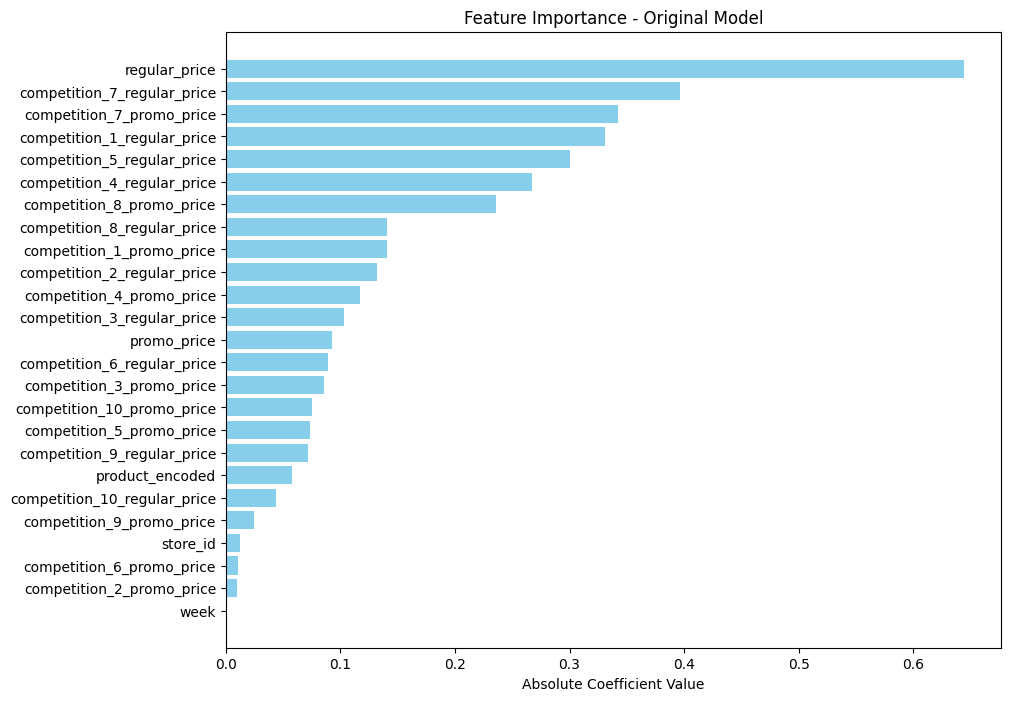


Feature Importance - Normalized Model:


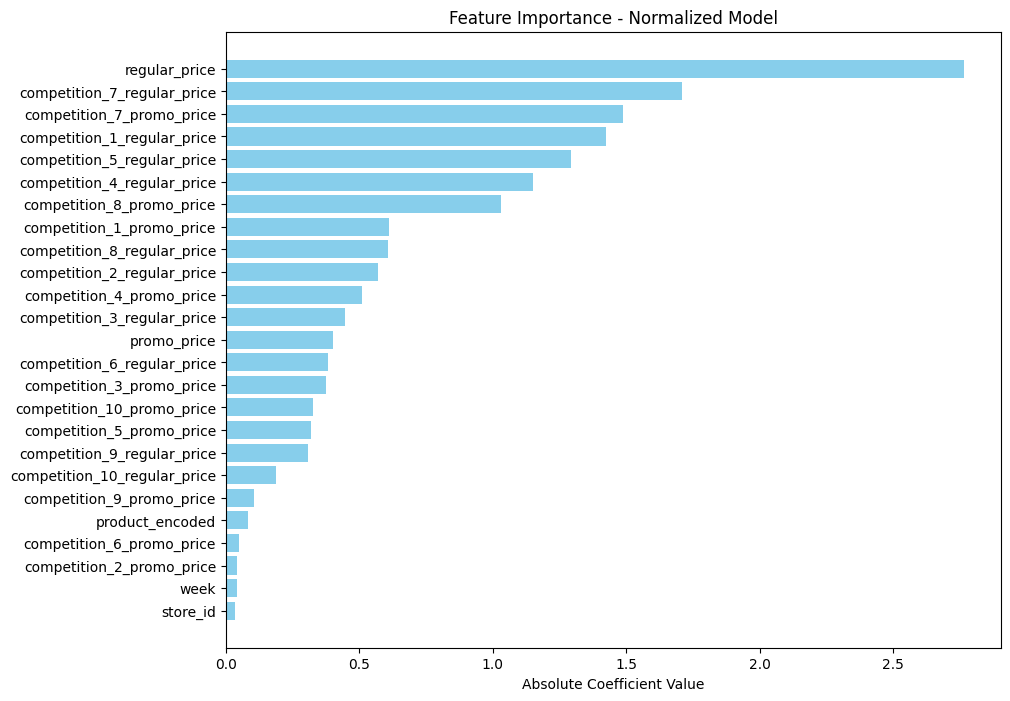


Top Features - Original Model:
                        Feature  Coefficient  Absolute Coefficient
2                 regular_price    -0.644307              0.644307
9   competition_7_regular_price     0.396289              0.396289
20    competition_7_promo_price    -0.342611              0.342611
3   competition_1_regular_price    -0.330883              0.330883
7   competition_5_regular_price     0.300006              0.300006

Top Features - Normalized Model:
                        Feature  Coefficient  Absolute Coefficient
2                 regular_price    -2.764157              2.764157
9   competition_7_regular_price     1.706512              1.706512
20    competition_7_promo_price    -1.488778              1.488778
3   competition_1_regular_price    -1.422257              1.422257
7   competition_5_regular_price     1.291684              1.291684


In [9]:

X = df.drop(columns=['quantity'])
y = df['quantity']
X_norm = df_normalized.drop(columns=['quantity'])
y_norm = df_normalized['quantity']

# Split both versions into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y_norm, test_size=0.2, random_state=42)

# Initialize and fit Linear Regression for both
model_original = LinearRegression()
model_normalized = LinearRegression()

model_original.fit(X_train, y_train)
model_normalized.fit(X_train_norm, y_train_norm)

# Predictions for both models
y_pred_original = model_original.predict(X_test)
y_pred_normalized = model_normalized.predict(X_test_norm)

# Evaluation metrics
def evaluate_model(y_test, y_pred, label="Model"):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{label} - Mean Squared Error (MSE): {mse}")
    print(f"{label} - Mean Absolute Error (MAE): {mae}")
    print(f"{label} - R-squared (R²): {r2}")
    return mse, mae, r2

# Evaluate both models
print("Evaluation of Original Model:")
evaluate_model(y_test, y_pred_original, label="Original Model")

print("\nEvaluation of Normalized Model:")
evaluate_model(y_test_norm, y_pred_normalized, label="Normalized Model")

# Feature importance for both models
def plot_feature_importance(model, feature_names, title="Feature Importance"):
    coefficients = model.coef_
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Absolute Coefficient': np.abs(coefficients)
    }).sort_values(by='Absolute Coefficient', ascending=False)

    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance['Feature'], feature_importance['Absolute Coefficient'], color='skyblue')
    plt.xlabel('Absolute Coefficient Value')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()
    return feature_importance

# Plot and display feature importance for interpretability
print("\nFeature Importance - Original Model:")
original_feature_importance = plot_feature_importance(model_original, X.columns, title="Feature Importance - Original Model")

print("\nFeature Importance - Normalized Model:")
normalized_feature_importance = plot_feature_importance(model_normalized, X_norm.columns, title="Feature Importance - Normalized Model")

# Display top features for interpretability analysis
print("\nTop Features - Original Model:")
print(original_feature_importance.head())

print("\nTop Features - Normalized Model:")
print(normalized_feature_importance.head())


In [10]:
import numpy as np
import os

# Define the directory to save the priors
save_directory = os.path.expanduser('~/Ferrero_Tech_Assesment/data/processed')

# Create the directory if it doesn't exist (optional, since you may have created it already)
os.makedirs(save_directory, exist_ok=True)

# Define the full path for the output file
file_path = os.path.join(save_directory, 'linear_model_priors.npz')

# Extract coefficients and intercept from both models
linear_coefs_original = model_original.coef_
linear_intercept_original = model_original.intercept_

linear_coefs_normalized = model_normalized.coef_
linear_intercept_normalized = model_normalized.intercept_

# Save coefficients and intercepts to a .npz file
np.savez(file_path, 
         coefs_original=linear_coefs_original, 
         intercept_original=linear_intercept_original,
         coefs_normalized=linear_coefs_normalized, 
         intercept_normalized=linear_intercept_normalized)

print(f"Linear model priors have been exported successfully to: {file_path}")

Linear model priors have been exported successfully to: /home/cian/Ferrero_Tech_Assesment/data/processed/linear_model_priors.npz


In [11]:

coefficients = model_original.coef_
feature_names = X.columns

# Create a DataFrame to analyze coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute Coefficient': np.abs(coefficients)
}).sort_values(by='Absolute Coefficient', ascending=False)

# Actionable Insights Function
def actionable_insights(feature_importance):
    print("\nActionable Insights:")
    
    # Insight: Impact of Regular Price
    regular_price_coef = feature_importance.loc[feature_importance['Feature'] == 'regular_price']
    if not regular_price_coef.empty:
        print(f"\nImpact of Regular Price: Coefficient = {regular_price_coef['Coefficient'].values[0]:.4f}")
        print("Recommendation: Consider evaluating the pricing strategy. A potential reduction in regular price could lead to an increase in sales quantity.")
    
    # Insight: Promotional Pricing Strategies
    promo_columns = feature_importance[feature_importance['Feature'].str.contains('promo_price')]
    for _, row in promo_columns.iterrows():
        print(f"\nPromotional Pricing Impact: {row['Feature']} - Coefficient = {row['Coefficient']:.4f}")
        if row['Coefficient'] < 0:
            print(f"Recommendation: Analyze the promotional strategies of competitors and consider offering competitive discounts for {row['Feature']}.")
    
    # Insight: Competitor Regular Prices
    competition_columns = feature_importance[feature_importance['Feature'].str.contains('competition') & feature_importance['Feature'].str.contains('regular_price')]
    for _, row in competition_columns.iterrows():
        print(f"\nCompetitor Regular Price Impact: {row['Feature']} - Coefficient = {row['Coefficient']:.4f}")
        if row['Coefficient'] > 0:
            print("Recommendation: Monitor competitor pricing closely; if a competitor raises their price, it may be an opportunity to increase our prices slightly.")
    
    # Insight: Retailer Analysis
    if 'retailer_retail2' in feature_names:
        retailer_coef = feature_importance.loc[feature_importance['Feature'] == 'retailer_retail2']
        print(f"\nRetailer Impact: {retailer_coef['Feature'].values[0]} - Coefficient = {retailer_coef['Coefficient'].values[0]:.4f}")
        print("Recommendation: Consider targeted marketing campaigns or reassessing product placement at this retailer.")
    
    # Insight: Quantity Lag Analysis
    if 'quantity_lag_1' in feature_names:
        lag_coef = feature_importance.loc[feature_importance['Feature'] == 'quantity_lag_1']
        print(f"\nQuantity Lag Impact: {lag_coef['Feature'].values[0]} - Coefficient = {lag_coef['Coefficient'].values[0]:.4f}")
        print("Recommendation: Use historical sales data to forecast future sales more accurately.")
    
    # Quantifiable Goals
    if 'regular_price' in feature_names:
        regular_price_value = X_test['regular_price'].mean()  # Example calculation using the mean price
        expected_increase = regular_price_coef['Coefficient'].values[0] * -0.10 * regular_price_value
        print(f"\nQuantifiable Goal: Reducing regular price by 10% may lead to an expected increase of {expected_increase:.2f} units sold.")
    
    print("\nOverall: Implement these strategies to improve product performance in the market.")

# Call the insights function with the feature importances
actionable_insights(feature_importance)





Actionable Insights:

Impact of Regular Price: Coefficient = -0.6443
Recommendation: Consider evaluating the pricing strategy. A potential reduction in regular price could lead to an increase in sales quantity.

Promotional Pricing Impact: competition_7_promo_price - Coefficient = -0.3426
Recommendation: Analyze the promotional strategies of competitors and consider offering competitive discounts for competition_7_promo_price.

Promotional Pricing Impact: competition_8_promo_price - Coefficient = 0.2359

Promotional Pricing Impact: competition_1_promo_price - Coefficient = 0.1404

Promotional Pricing Impact: competition_4_promo_price - Coefficient = -0.1170
Recommendation: Analyze the promotional strategies of competitors and consider offering competitive discounts for competition_4_promo_price.

Promotional Pricing Impact: promo_price - Coefficient = -0.0924
Recommendation: Analyze the promotional strategies of competitors and consider offering competitive discounts for promo_price.


### Ridge Regression

In [12]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define Ridge Regression model
ridge = Ridge()

# Hyperparameter tuning for alpha (regularization strength)
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best model with optimized alpha
best_ridge = grid_search.best_estimator_

# Predict and evaluate on test set
y_pred = best_ridge.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Ridge Regression - Best Alpha: {grid_search.best_params_['alpha']}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")


Ridge Regression - Best Alpha: 1000
Mean Squared Error (MSE): 16.722888208335224
Mean Absolute Error (MAE): 3.3793985657518726
R-squared (R²): -0.0008018363570416742


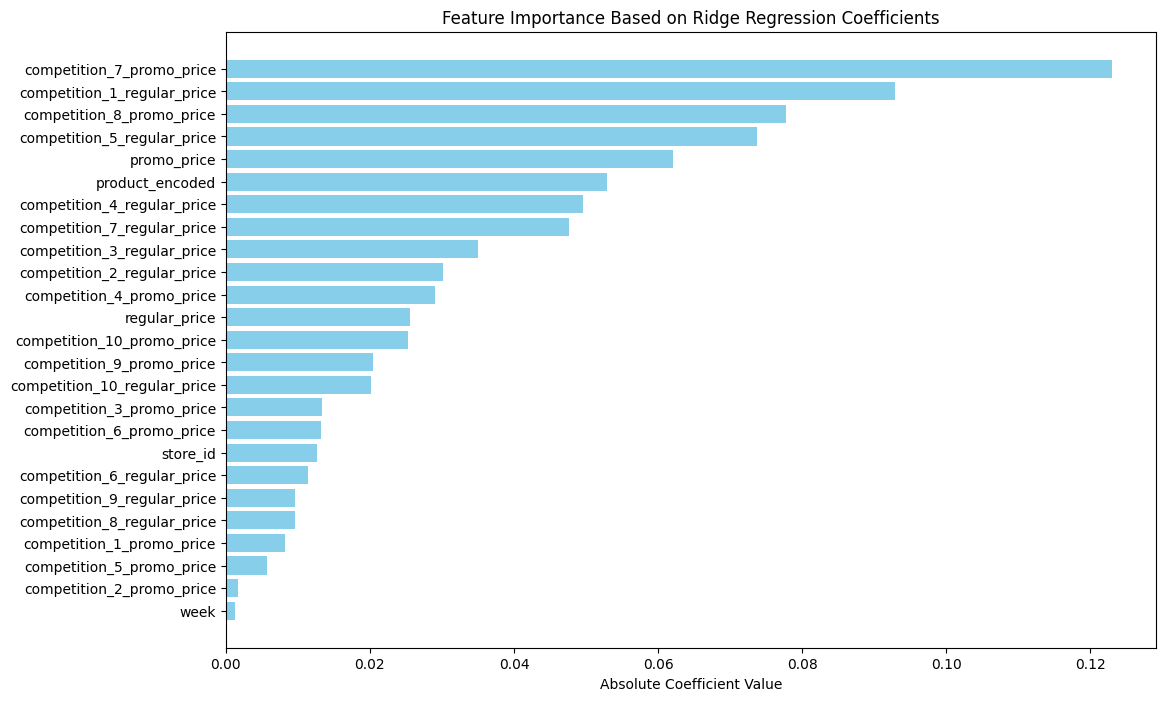

Feature Importance Table (Ridge Regression):
                         Feature  Coefficient  Absolute Coefficient
20     competition_7_promo_price    -0.122949              0.122949
3    competition_1_regular_price    -0.092862              0.092862
21     competition_8_promo_price     0.077819              0.077819
7    competition_5_regular_price     0.073778              0.073778
13                   promo_price    -0.062047              0.062047
24               product_encoded     0.052930              0.052930
6    competition_4_regular_price     0.049628              0.049628
9    competition_7_regular_price     0.047609              0.047609
5    competition_3_regular_price    -0.035070              0.035070
4    competition_2_regular_price     0.030150              0.030150
17     competition_4_promo_price    -0.029026              0.029026
2                  regular_price    -0.025496              0.025496
23    competition_10_promo_price     0.025219              0.025219
22 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Retrieve coefficients from the best Ridge model
coefficients = best_ridge.coef_

# Feature importance DataFrame
feature_importance = pd.DataFrame({
    'Feature': X.columns,  
    'Coefficient': coefficients,
    'Absolute Coefficient': np.abs(coefficients)
}).sort_values(by='Absolute Coefficient', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'], feature_importance['Absolute Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance Based on Ridge Regression Coefficients')
plt.gca().invert_yaxis()
plt.show()

# Display feature importance table
print("Feature Importance Table (Ridge Regression):")
print(feature_importance)

### XGBoost

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

Mean Squared Error (MSE): 19.17
Mean Absolute Error (MAE): 3.60
R-squared (R²): -0.15
Root Mean Squared Error (RMSE): 4.38


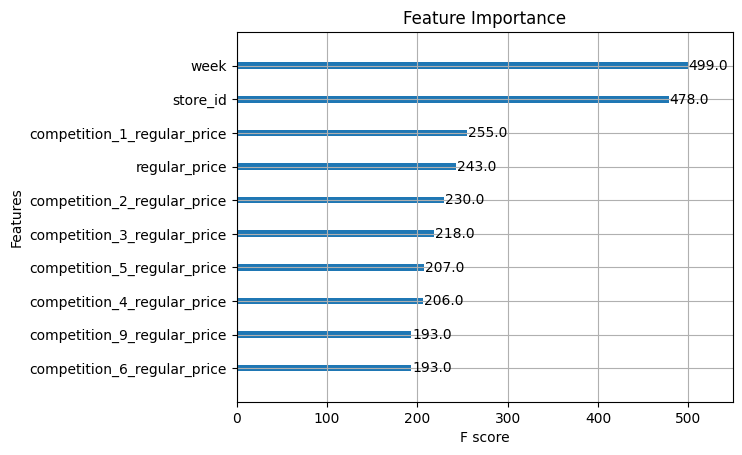

In [15]:
X = df.drop(columns=['quantity'])
y = df['quantity']


# Split both versions into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define the model with default parameters
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)


xg_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = xg_reg.predict(X_test)


# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")


rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

xgb.plot_importance(xg_reg, max_num_features=10)
plt.title('Feature Importance')
plt.show()


/home/cian/Ferrero_Tech_Assesment/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


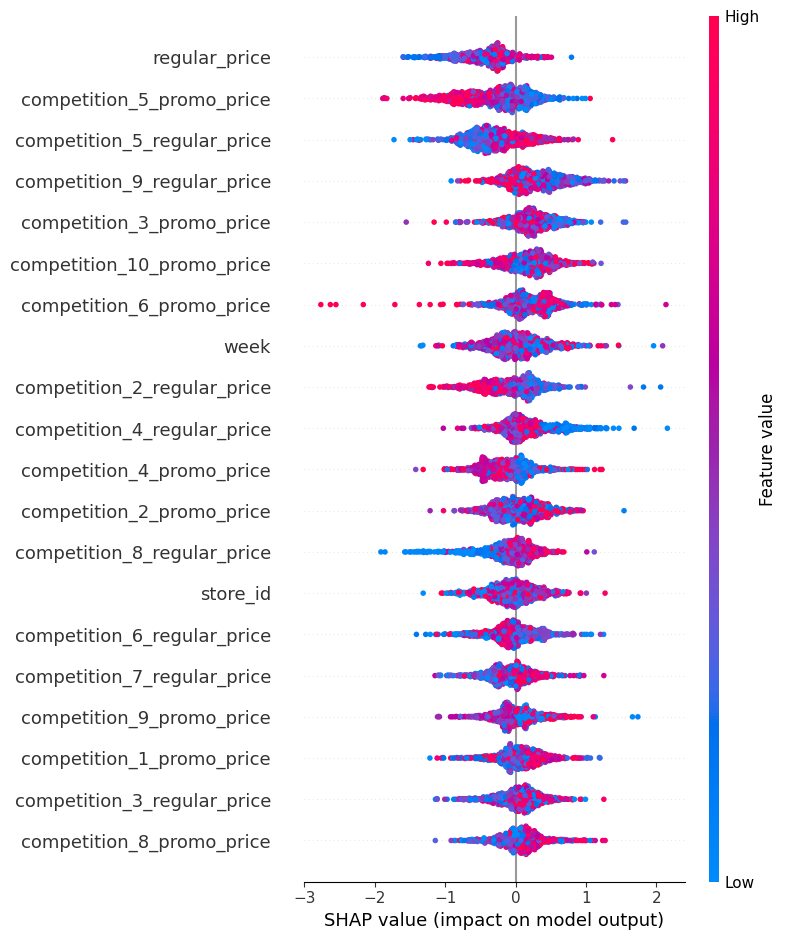

In [16]:
import shap

# Initialize the JS visualization code
shap.initjs()

# Explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X_test)

# Plot summary plot
shap.summary_plot(shap_values, X_test)


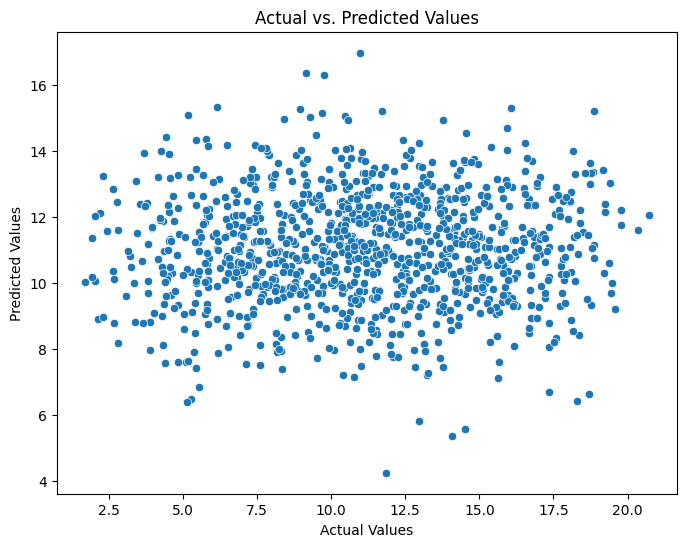

In [17]:
# Plotting the predicted vs actual values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()


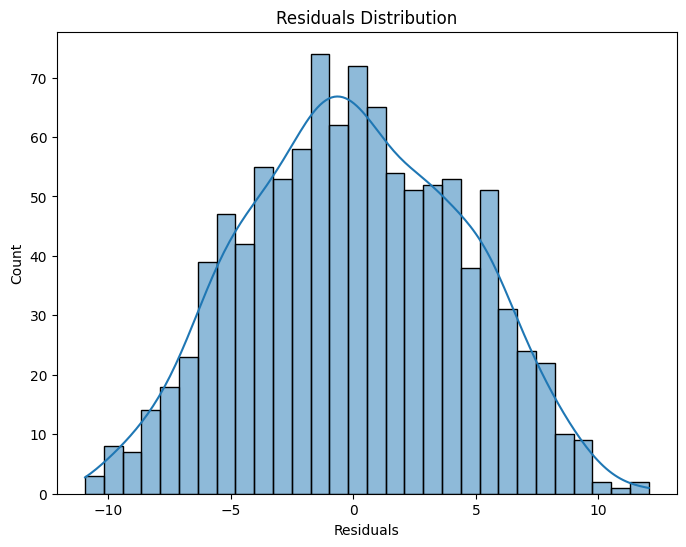

In [18]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('Residuals')
plt.title('Residuals Distribution')
plt.show()


In [19]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator
best_xg_reg = grid_search.best_estimator_

# Predict with the best model
y_pred_best = best_xg_reg.predict(X_test)

# Evaluate the best model
best_mse = mean_squared_error(y_test, y_pred_best)
best_mae = mean_absolute_error(y_test, y_pred_best)
best_r2 = r2_score(y_test, y_pred_best)

print(f"Best Model Mean Squared Error (MSE): {best_mse:.2f}")
print(f"Best Model Mean Absolute Error (MAE): {best_mae:.2f}")
print(f"Best Model R-squared (R²): {best_r2:.2f}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Model Mean Squared Error (MSE): 16.69
Best Model Mean Absolute Error (MAE): 3.37
Best Model R-squared (R²): 0.00
